In [1]:
import torch
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
from torch.special import gammaln

In [2]:
DEVICE = "cpu" # NOTE MacM2 processor is mps , cpu should be default  , if CUDA support and installed use cuda instead
SEED=3012024

In [50]:
torch.manual_seed(SEED)

## using the provided resource as base architecture
class VAE(nn.Module):
    def __init__(self, hidden_dims, data_dim=784, device=DEVICE):
        super().__init__()
        # assert len(hidden_dims) == 5, "Insufficiently number of dimensions!"
        self.data_dim = data_dim
        self.device = device

        dim_enc, dim_mu_in, dim_mu_out, dim_dec, dim_dec, dim_alpha, dim_out = hidden_dims

        # define IO
        self.in_layer = nn.Linear(data_dim, dim_enc)

        # hidden layer
        self.enc_h = nn.Linear(dim_enc, dim_mu_in)
        # define hidden and latent
        self.enc_mu = nn.Linear(dim_mu_in, dim_mu_out)
        self.enc_sigma = nn.Linear(dim_mu_in, dim_mu_out)
        # hidden layer decoder
        self.dec_h = nn.Linear(dim_mu_out, dim_dec)
        self.dec_layer = nn.Linear(dim_dec, dim_alpha)
        self.alpha_layer1 = nn.Linear(dim_alpha, dim_out)
        self.alpha_layer2 = nn.Linear(dim_out, data_dim)

        self.beta_layer1 = nn.Linear(dim_alpha,dim_out)
        self.beta_layer2 = nn.Linear(dim_out, data_dim)

        self.to(device)
        
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h1 = F.relu(self.in_layer(x))
        h2 = F.relu(self.enc_h(h1))
        return self.enc_mu(h2), self.enc_sigma(h2)

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        h3 = F.relu(self.dec_h(z))
        h4 = F.relu(self.dec_layer(h3))
        #torch.sigmoid(self.out_layer(h4))

        # layers for alpha
        alpha = F.relu(self.alpha_layer1(h4))
        alpha = F.sigmoid(self.alpha_layer2(alpha))

        # layers for beta
        beta = F.relu(self.beta_layer1(h4))
        beta = F.sigmoid(self.beta_layer2(beta))

        return alpha, beta

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x.view(-1, self.data_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def train(model: VAE, epoch: int, train_loader: torch.utils.data.DataLoader, log_interval: int=25) -> list:
    model.train()
    train_loss = 0.
    train_loss_vals = []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(model.device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(x)
        loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
        loss_val.backward()
        train_loss += loss_val.item()
        train_loss_vals.append(loss_val.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(f"Train epoch={epoch} [{batch_idx*len(x)}/{len(train_loader.dataset)}]\t loss={loss_val.item() / len(x)}")
            print(f"BETA={ce:.2f} KLD={kld:.2f}")
            
    print(f"===> epoch={epoch} avrg.loss={train_loss/len(train_loader.dataset)}")
    return train_loss_vals

In [5]:
def test(model: VAE, epoch: int, test_loader: torch.utils.data.DataLoader) -> list:
    model.eval()
    test_loss = 0.
    test_loss_vals = []
    with torch.no_grad():
        for i, (x, _) in enumerate(test_loader):
            x = x.to(model.device)
            recon_batch, mu, logvar = model(x)
            test_loss_val, ce, kld = loss(recon_batch, x, mu, logvar)
            test_loss += test_loss_val.item()
            test_loss_vals.append(test_loss_val.item())
            # if i == 0: # TODO: do we want to persist images here?
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([x[:n], ])
    test_loss /= len(test_loader.dataset)
    print(f"===> Test loss={test_loss}")
    return test_loss_vals

In [6]:
# lets use torch datasets with our data
class DatasetWrapper(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [5]:
# Download csv files
#%pip install gdown

train_filename = 'mnist_train.csv'
test_filename = 'mnist_test.csv'

if not(os.path.exists(train_filename) and os.path.exists(test_filename)):
    train_id = '1UYlB8NsA2K8jZkDVlYo7_S-K5d66fwsZ'
    test_id = '1_t_RPAnMZnLBw3jbV2eTX1Gy3qP8vm6T'
    base_url = 'https://drive.google.com/uc?id='
    gdown.download(base_url + train_id, train_filename, quiet=False)
    gdown.download(base_url + test_id, test_filename, quiet=False)

In [7]:
## load the MNIST data we've used previously
## use torch dataloader object for the heavy lifting

mnist_train = np.loadtxt("mnist_train.csv", delimiter=",", dtype=np.float32, skiprows= 1)
mnist_test = np.loadtxt("mnist_test.csv", delimiter=",", dtype=np.float32, skiprows= 1)
train_labels = mnist_train[:,0]
train_data = mnist_train[:,1:] / 255
test_labels = mnist_test[:,0]
test_data = mnist_test[:,1:] / 255 #NOTE: don't forget to standardize

train_data.shape, test_data.shape

train_ds = DatasetWrapper(train_data, train_labels)
test_ds = DatasetWrapper(test_data, test_labels)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

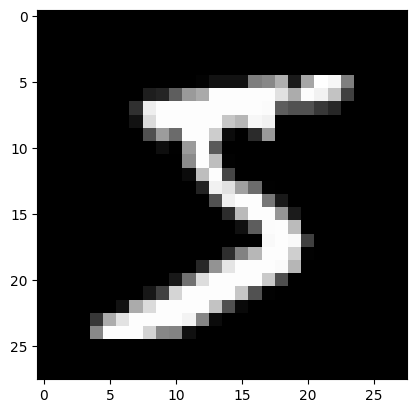

In [8]:
plt.imshow(train_data[0].reshape(28, 28), cmap = "gray")

In [51]:
EPOCHS=10

# 3.) modify the network architecture and try to obtain a better embedding
model = VAE(hidden_dims=[300, 50, 2, 50, 256, 300, 512]) # NOTE: 2D latent space
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor, clamp = -25) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    #assert recon_x.shape[0] == x.shape[0] and recon_x.shape[-1] == x.shape[-1], "Shape Mismatch between reconstruction and x"
    
    x = x.view(-1, 784)
    beta_term = 0
    alpha_x, beta_x = recon_x
    part_a = torch.log(x)
    part_a[part_a < clamp] = clamp
    part_b = torch.log(1-x)
    part_b[part_b < clamp] = clamp

    beta_term = (alpha_x-1)*part_a + (beta_x -1)*part_b - gammaln(alpha_x) - gammaln(beta_x) + gammaln(alpha_x + beta_x)
    beta_term = -torch.sum(beta_term)
    
    KLD = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return beta_term + KLD, beta_term, KLD # = -ELBO



In [52]:
train_loss_vals_total = []
test_loss_vals_total = []
for e in range(1, EPOCHS+1):
    train_loss_vals = train(model, epoch=e, train_loader=train_loader)
    test_loss_vals = test(model, epoch=e, test_loader=test_loader)
    train_loss_vals_total.append(train_loss_vals)
    test_loss_vals_total.append(test_loss_vals)
    plt.plot(np.arange(1, e+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
    plt.plot(np.arange(1, e+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss\n BCE+KLD")
    # plt.yscale("log")
    plt.title("VAE avrg. training loss per epoch")
    plt.legend()
    plt.savefig("current_error_beta.png")
    plt.close()

Train epoch=1 [0/60000]	 loss=-7322.4677734375
BETA=-937278.00 KLD=2.15
Train epoch=1 [3200/60000]	 loss=-12961.408203125
BETA=-1659062.88 KLD=2.59
Train epoch=1 [6400/60000]	 loss=-13065.177734375
BETA=-1672344.50 KLD=1.80
Train epoch=1 [9600/60000]	 loss=-13190.875
BETA=-1688437.62 KLD=5.67
Train epoch=1 [12800/60000]	 loss=-13034.5048828125
BETA=-1668431.00 KLD=14.31
Train epoch=1 [16000/60000]	 loss=-13068.6455078125
BETA=-1672811.50 KLD=24.84
Train epoch=1 [19200/60000]	 loss=-13175.2138671875
BETA=-1686474.62 KLD=47.25
Train epoch=1 [22400/60000]	 loss=-13074.9560546875
BETA=-1673682.75 KLD=88.31
Train epoch=1 [25600/60000]	 loss=-13093.419921875
BETA=-1676092.50 KLD=134.76
Train epoch=1 [28800/60000]	 loss=-13101.3359375
BETA=-1677186.75 KLD=215.78
Train epoch=1 [32000/60000]	 loss=-13074.5478515625
BETA=-1673810.12 KLD=268.02
Train epoch=1 [35200/60000]	 loss=-13158.783203125
BETA=-1684562.25 KLD=238.05
Train epoch=1 [38400/60000]	 loss=-13211.3896484375
BETA=-1691305.12 KLD=24

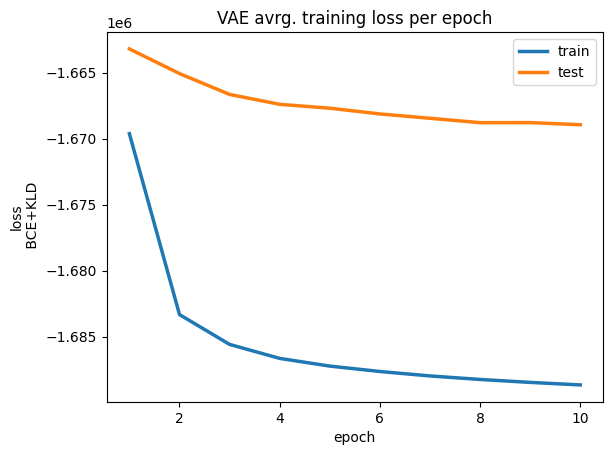

In [53]:
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in train_loss_vals_total], lw=2.5, label="train")
plt.plot(np.arange(1, EPOCHS+1), [np.mean(ls) for ls in test_loss_vals_total], lw=2.5, label="test")
plt.xlabel("epoch")
plt.ylabel("loss\n BCE+KLD")
# plt.yscale("log")
plt.title("VAE avrg. training loss per epoch")
plt.legend()
plt.show()

In [20]:
steps = 12
vals = torch.linspace(0.05, 0.95, steps=steps)
x, y = torch.meshgrid(vals, vals, indexing='xy')
z1 = torch.distributions.normal.Normal(0,1).icdf(x)
z2 = torch.distributions.normal.Normal(0,1).icdf(y)

reps = []
with torch.no_grad():
  for i in range(steps):
    for j in range(steps):
      z = torch.tensor([z1[i, j], z2[i, j]])
      alpha, beta =model.decode(z) 
      reps.append((alpha / (alpha + beta)).reshape(28, 28))




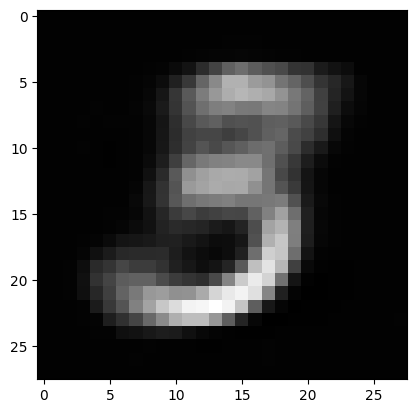

In [54]:
with torch.no_grad():
    alpha, beta = model(torch.tensor(train_data[0]))[0]
    plt.imshow((alpha / (alpha + beta)).reshape(28, 28), cmap = "gray")

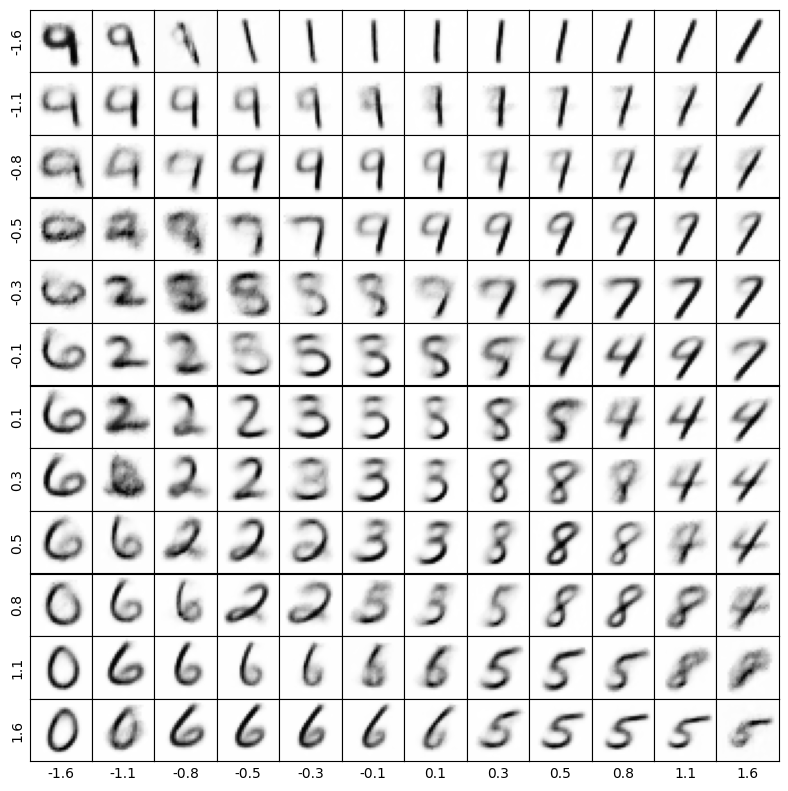

In [15]:
fig, ax = plt.subplots(nrows = steps, ncols = steps, figsize=(8,8), gridspec_kw = {'wspace':0, 'hspace':0, })
for i in range(steps):
  for j in range(steps):
    n = i * steps + j
    ax[i, j].imshow(reps[n], cmap ="Greys")
    if j == 0:
      ax[i, j].set_ylabel(f"{z2[i,j].item():.1f}")
    if i == steps - 1:
      ax[i, j].set_xlabel(f"{z1[i,j].item():.1f}")

plt.tight_layout(w_pad=0., pad=0., h_pad=0.)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.savefig("Bern_output_continuous.jpg")

In [16]:
diffs = []

for img in test_data:
    img = torch.tensor(img)
    alpha, beta = model(img)[0]
    diffs.append(torch.mean((img - (alpha / (alpha + beta))) ** 2).item())


In [17]:
np.mean(diffs)

0.040684073301567696

In [56]:
num = 50
fig, ax = plt.subplots(nrows = num, ncols = 2, figsize=(8,num), gridspec_kw = {'wspace':0.5, 'hspace':0, }, dpi = 1200)
with torch.no_grad():
    for i in range(num):
        img = torch.tensor(test_data[i])
        ax[i, 0].imshow(img.reshape(28, 28), cmap = "gray")
        alpha, beta = model(img)[0]
        ax[i, 1].imshow((alpha / (alpha + beta)).reshape(28, 28), cmap = "gray")
        
        # ax[i, 1].imshow(np.random.beta(alpha.numpy(), beta.numpy()).reshape(28, 28), cmap = "gray")
        

ax[0, 0].set_title("Original")
ax[0, 1].set_title("Beta")
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])


[]